In [42]:
import os
import importlib

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from customer_segmentation.utils import functions
importlib.reload(functions)

# Set pandas to display all columns
pd.set_option('display.max_columns', None)

In [2]:
# import data
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, os.path.pardir, "data")
file_name = 'cohort_data.csv'
file_path = os.path.join(data_dir, file_name)

cohort = pd.read_csv(file_path)

In [3]:
cohort.head()

,user_id,age,has_children,is_married,cnt_trips,avg_diff_trip_days,days_last_trip,avg_days_advance_booking,avg_travel_days,avg_seats,avg_flight_travel_days,avg_distance_km,avg_rooms,avg_hotel_nights,min_signup_date,days_active,avg_session_duration_seconds,has_flight_booked,has_hotel_booked,avg_flight_discount,avg_hotel_discount,month_active,sessions_per_month,trips_per_month,page_click_per_session,avg_booking_value,customer_value_per_month,total_discount_rate,discount_per_km,cancellation_rate
0,264579,26,0,0,2,26.0,247,8.0,4.0,1.0,4.0,877.0,1.0,3.0,2022-07-28,273,129.0,1,1,0.15,0.13,9.100000,0.879121,0.219780,17.500000,1348.575,296.390110,0.00,0.00000,0.0
1,264581,21,1,0,1,0.0,335,5.0,8.0,0.0,0.0,0.0,1.0,8.0,2022-07-28,347,63.0,0,1,0.13,0.08,11.566667,0.605187,0.086455,8.428571,1320.000,114.121037,0.05,NaN,0.0
2,264582,42,0,1,3,107.0,110,7.0,4.0,1.0,4.0,2533.0,1.0,3.0,2022-07-28,323,216.0,1,1,0.15,0.10,10.766667,0.650155,0.278638,29.285714,623.610,173.761300,0.00,0.00000,0.0
3,264584,46,0,1,4,54.0,60,9.0,5.0,1.0,5.0,3279.0,1.0,4.0,2022-07-28,223,149.0,1,1,0.08,0.00,7.433333,1.076233,0.538117,20.000000,929.670,500.270852,0.01,0.00264,0.0
4,264586,50,1,1,5,66.0,17,6.0,5.0,1.0,6.0,2034.0,1.0,4.0,2022-07-28,281,198.0,1,1,0.00,0.00,9.366667,0.640569,0.533808,26.500000,469.086,250.401779,0.00,0.00000,0.0


In [4]:
# convert data types
cohort['user_id'] = cohort['user_id'].astype(str)
cohort['cnt_trips'] = cohort['cnt_trips'].astype(int)
cohort['min_signup_date'] = pd.to_datetime(cohort['min_signup_date'])

**RFM analysis**

In [ ]:
# Recency: days_last_trip
# Frequency: trips_per_month
# Monetary: customer_value_per_month

cohort['R_score'] = pd.qcut(cohort['days_last_trip'], q=5, labels=[5, 4, 3, 2, 1])
cohort['F_score'] = pd.qcut(cohort['trips_per_month'], q=5, labels=[1, 2, 3, 4, 5])
cohort['M_score'] = pd.qcut(cohort['customer_value_per_month'], q=5, labels=[1, 2, 3, 4, 5])

cohort['RFM_score'] = cohort[['R_score','F_score','M_score']].astype(int).sum(axis=1)

In [40]:
conditions = [
    (cohort['RFM_score'] >= 13),
    (cohort['RFM_score'] >= 10) & (cohort['RFM_score'] < 13),
    (cohort['RFM_score'] >= 7)  & (cohort['RFM_score'] < 10),
    (cohort['RFM_score'] >= 4)  & (cohort['RFM_score'] < 7),
    (cohort['RFM_score'] < 4),
]

labels = [
    'Champions',
    'Loyal Customers',
    'Potential Loyalists',
    'At risk',
    'Lost',
]

cohort['RFM_groups'] = np.select(conditions, labels, default='Unknown')
cohort['RFM_groups'] = cohort['RFM_groups'].astype('category')
cohort['RFM_groups'] = cohort['RFM_groups'].cat.reorder_categories(labels, ordered=True)

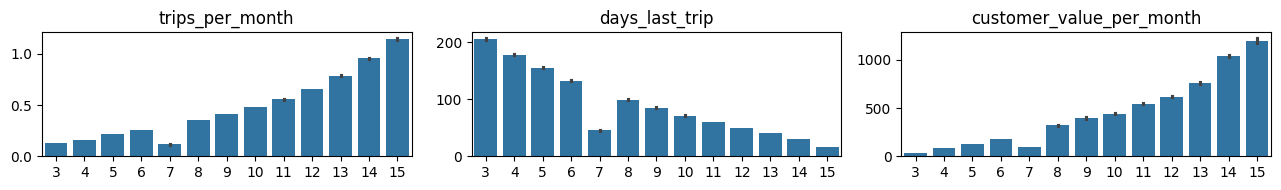

In [46]:
metrics = ['trips_per_month', 'days_last_trip', 'customer_value_per_month']

functions.plot_bivariate_series(df=cohort, category='RFM_score', metrics=metrics, n_cols=3)

In [41]:
grouped_cohort = cohort.groupby('RFM_groups', observed=True).agg(
    cnt_user = ('user_id', 'nunique'),
    days_last_trip = ('days_last_trip', 'mean'),
    trips_per_month = ('trips_per_month', 'mean'),
    customer_value_per_month = ('customer_value_per_month', 'mean'),  
    
).reset_index()
grouped_cohort

,RFM_groups,cnt_user,days_last_trip,trips_per_month,customer_value_per_month
0,Champions,27962,33.322545,0.903758,933.455232
1,Loyal Customers,44866,60.518410,0.562958,531.821567
2,Potential Loyalists,67117,66.927306,0.240103,218.581473
3,At risk,28786,150.400577,0.220676,140.340981
4,Lost,3624,205.661700,0.127987,37.716792


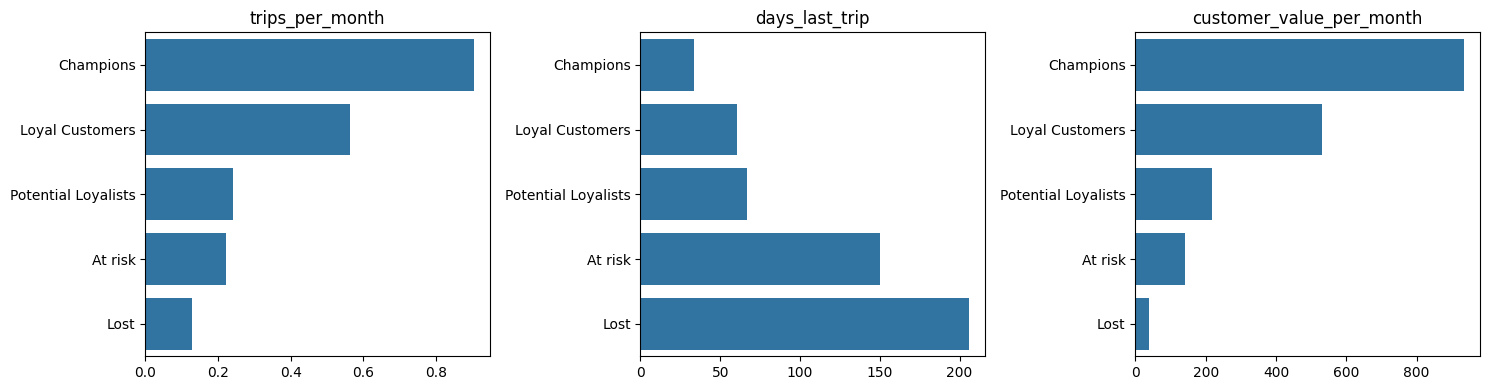

In [66]:
metrics = ['trips_per_month', 'days_last_trip', 'customer_value_per_month']
_, axes = plt.subplots(1, 3, figsize = (15, 4))
axes = axes.flatten()
for i, col in enumerate(metrics):
    sns.barplot(data=grouped_cohort, x=col, y='RFM_groups', ax = axes[i])  
    axes[i].set_title(f"{col}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
plt.tight_layout()
plt.show()

**cohort analysis**

In [70]:
sorted(cohort.columns.to_list())

['F_score',
 'M_score',
 'RFM_groups',
 'RFM_score',
 'R_score',
 'age',
 'avg_booking_value',
 'avg_days_advance_booking',
 'avg_diff_trip_days',
 'avg_distance_km',
 'avg_flight_discount',
 'avg_flight_travel_days',
 'avg_hotel_discount',
 'avg_hotel_nights',
 'avg_rooms',
 'avg_seats',
 'avg_session_duration_seconds',
 'avg_travel_days',
 'cancellation_rate',
 'cnt_trips',
 'cohort_month',
 'customer_value_per_month',
 'days_active',
 'days_last_trip',
 'discount_per_km',
 'has_children',
 'has_flight_booked',
 'has_hotel_booked',
 'is_married',
 'min_signup_date',
 'min_signup_yearmonth',
 'month_active',
 'page_click_per_session',
 'sessions_per_month',
 'total_discount_rate',
 'trips_per_month',
 'user_id']

In [82]:
cohort['cohort_month'] = cohort['min_signup_date'].dt.strftime('%Y-%m')
cohort['cohort_age'] = cohort['month_active'].apply(np.floor)


retention = cohort.groupby(['cohort_month','cohort_age'])['user_id'].nunique().reset_index()
cohort_sizes = retention[retention['cohort_age']==1][['cohort_month','user_id']]
cohort_sizes = cohort_sizes.rename(columns={'user_id': 'cohort_size'})
retention = retention.merge(cohort_sizes, on='cohort_month')
retention['retention_rate'] = retention['user_id'] / retention['cohort_size']

In [83]:
retention_pivot = retention.pivot_table(
    index='cohort_month',
    columns='cohort_age',
    values='retention_rate'
)

retention_pivot

cohort_age,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
cohort_month,,,,,,,,,,,
2022-07,1.0,3.000000,8.000000,26.000000,102.000000,241.000000,374.000000,279.000000,328.000000,384.000000,379.0
2022-08,1.0,6.333333,33.666667,127.333333,415.333333,818.666667,964.333333,761.000000,900.666667,1051.666667,375.0
2022-09,1.0,13.333333,113.000000,417.333333,847.333333,1000.000000,825.333333,981.000000,1118.333333,363.333333,NaN
2022-10,1.0,11.958333,50.500000,118.791667,143.541667,124.875000,148.708333,174.041667,56.000000,NaN,NaN
2022-11,1.0,7.792857,21.628571,27.664286,24.028571,30.535714,36.371429,10.657143,NaN,NaN,NaN
2022-12,1.0,4.571203,6.351266,6.158228,7.577532,9.177215,2.920886,NaN,NaN,NaN,NaN
2023-01,1.0,2.287789,2.467327,3.407921,3.995380,1.154455,NaN,NaN,NaN,NaN,NaN
2023-02,1.0,1.737971,2.908406,3.775652,1.052754,NaN,NaN,NaN,NaN,NaN,NaN
2023-03,1.0,3.043331,5.313473,1.857820,NaN,NaN,NaN,NaN,NaN,NaN,NaN


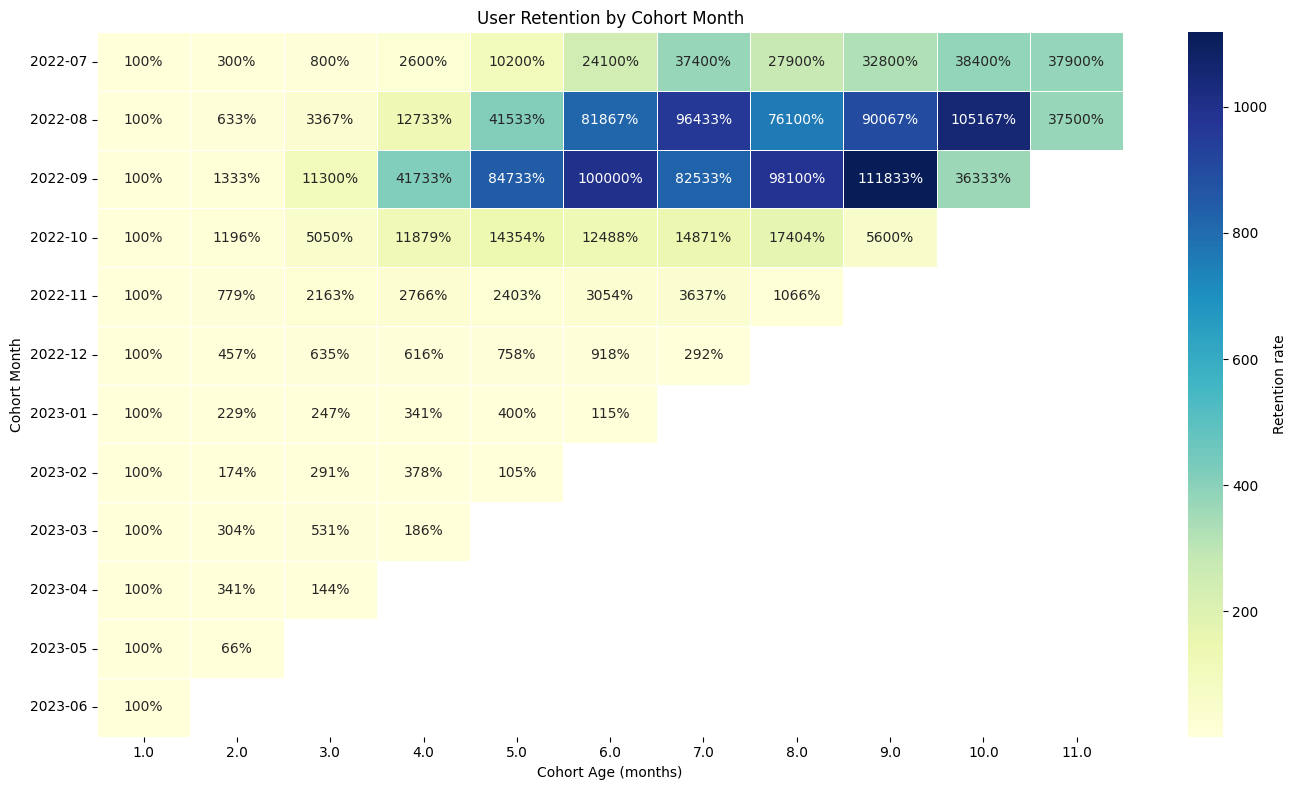

In [ ]:
plt.figure(figsize=(14, 8))
sns.heatmap(
    retention_pivot, 
    cmap='YlGnBu', 
    annot=True, 
    fmt=".0%", 
    cbar_kws={'label': 'Retention rate'},
    linewidths=0.5
)

plt.title('User Retention by Cohort Month')
plt.ylabel('Cohort Month')
plt.xlabel('Cohort Age (months)')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()